## This notebook is the solution for Question 1 in he Olive Diagnostic home Assignmnet

### Imports

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from typing import Dict, Any
import itertools

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Uploading the ata

In [2]:
raw_data = pd.read_csv('data_for_classification.csv')
raw_data.head(10)

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.549671,6.463089,1.026997,0,64,Male,81.913568,9.099271,1
1,2,0.486174,6.954708,1.024623,0,51,Female,97.284908,9.665405,1
2,3,0.564769,5.300716,1.020298,0,67,Female,95.883400,9.347795,0
3,4,NaN,6.281485,1.016765,0,41,Female,NaN,9.621079,0
4,5,0.476585,5.674679,1.023491,0,23,Female,96.926143,9.143055,0
5,6,0.476586,5.756437,1.021967,0,24,Male,98.981833,10.345089,0
6,7,0.657921,5.703803,1.024476,0,56,Female,NaN,9.962699,1
7,8,NaN,5.568005,1.023176,0,60,Male,83.292204,9.515891,0
8,9,0.453053,6.024261,1.025248,0,68,Female,111.060597,10.364557,0
9,10,0.554256,5.584525,1.017324,0,32,Male,117.116991,9.537140,0


### Parameters

In [21]:
features = raw_data.columns[1:-1] # no need to compute for Patient_ID
label = 'Condition'
categorical_features = ['Gender', 'Blood']
continous_features = features.difference(categorical_features)

### Data Handeling

#### Checking for Imbalencing

In [86]:
from operator import is_
def plot_pie_chart(
    data: pd.DataFrame,
    feature: str = label,
    ):
  """
  plot pie chart for a given feature
  Parameters:
  - data (pd.DataFrame): The input DataFrame containing patient urine analysis results and labels.
  - feature (str): The name of the column indicating the presence or absence of the medical condition.
  """
  feature_value_counts = data[feature].value_counts()
  feature_value_counts.plot(kind='pie', autopct='%1.1f%%')
  plt.title(f'Distribution of {feature}')
  plt.ylabel('')
  plt.show()

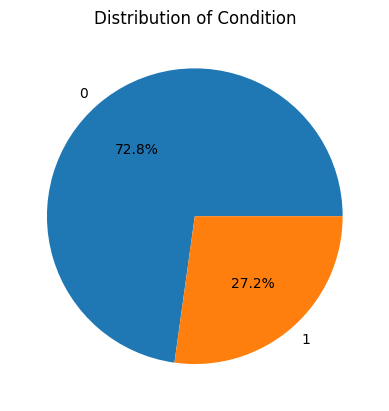

In [87]:
plot_pie_chart(raw_data)

The label is imbalanced, there is significantly higher number of not-healthy indivisuals. I will handle it later on

#### Checking for features types

There are outliers in some features - protein, pH, Specific_Gravity, Glucose, and Calcium.

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        500 non-null    int64  
 1   Protein           450 non-null    float64
 2   pH                450 non-null    float64
 3   Specific_Gravity  450 non-null    float64
 4   Blood             500 non-null    int64  
 5   Age               500 non-null    int64  
 6   Gender            500 non-null    object 
 7   Glucose           450 non-null    float64
 8   Calcium           500 non-null    float64
 9   Condition         500 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 39.2+ KB


There are 9 numeric features, and 1 categorical - 'Gender'. We should map it to numeric values

As can be seen, 'Gender' has to classes- Male and Female
the simplest way to encode to numeric values it is to map it to corresponding numeric values, such as 1 and 0. This maaping actions is simple beacuse this feature has only two classes, and it is not the predicted label (that would be 'Condition')

In [5]:
mapper = {'Male': 1, 'Female': 0}
raw_data['Gender'] = raw_data['Gender'].map(mapper)

raw_data.head(10)

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.549671,6.463089,1.026997,0,64,1,81.913568,9.099271,1
1,2,0.486174,6.954708,1.024623,0,51,0,97.284908,9.665405,1
2,3,0.564769,5.300716,1.020298,0,67,0,95.883400,9.347795,0
3,4,NaN,6.281485,1.016765,0,41,0,NaN,9.621079,0
4,5,0.476585,5.674679,1.023491,0,23,0,96.926143,9.143055,0
5,6,0.476586,5.756437,1.021967,0,24,1,98.981833,10.345089,0
6,7,0.657921,5.703803,1.024476,0,56,0,NaN,9.962699,1
7,8,NaN,5.568005,1.023176,0,60,1,83.292204,9.515891,0
8,9,0.453053,6.024261,1.025248,0,68,0,111.060597,10.364557,0
9,10,0.554256,5.584525,1.017324,0,32,1,117.116991,9.537140,0


#### Handeling NaN values

Handleing NaN values approaches are vary between discrad the rows and applying different mathematical techniques such as putting the mean or the meidan value of all the other values, in order to preserve the values scale. First, I think that there is no reason to discard these NaN values, and by looking on the features with NaN values, it can be seen that all of them are continus numeric. Therefore, I think that the right decision is to fill them the median value, because it less sensitive for outliers.

In [6]:
raw_data.isnull().sum()

,0
Patient_ID,0
Protein,50
pH,50
Specific_Gravity,50
Blood,0
Age,0
Gender,0
Glucose,50
Calcium,0
Condition,0


There are some NaN values

Putting the median value

In [7]:
nan_columns = raw_data.columns[raw_data.isna().any()].tolist() # taking only columns with NaN values

for column in nan_columns:
    raw_data[column].fillna(raw_data[column].median(), inplace=True)

print(raw_data.isnull().sum()) # Checking action worked
print()
print(raw_data.info())

Patient_ID          0
Protein             0
pH                  0
Specific_Gravity    0
Blood               0
Age                 0
Gender              0
Glucose             0
Calcium             0
Condition           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        500 non-null    int64  
 1   Protein           500 non-null    float64
 2   pH                500 non-null    float64
 3   Specific_Gravity  500 non-null    float64
 4   Blood             500 non-null    int64  
 5   Age               500 non-null    int64  
 6   Gender            500 non-null    int64  
 7   Glucose           500 non-null    float64
 8   Calcium           500 non-null    float64
 9   Condition         500 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 39.2 KB
None


#### Checking for outliers

There are few common methods for checking for outliers, the most two common are Z-Scores for nurmal distributed data, and IQR for non-normal distributed. This combined approach allows to leverage the strengths of each method, ensuring that outlier detection is both accurate and appropriate for the naature of the data.

Handeling outliers has two main approaches- discard the outliers, and keep them while performing actions to reduce their effect. Meanwhile, in medical data, outliers can provide a crucial diagnostic information. For example, high glucose might indicate diabetes.
Therfore, I think the second approach is the appropriate approach.

There are some techniques for handleing outliers- transformation (in order to reduce their impact), and imputation (considering them as missing values and treat them as such). I think that the transformation approach is the appropriate one, because of the reason as described above.



In [8]:
def identify_and_transform_outliers(
    data: pd.DataFrame,
    exclude_columns: list,
    label : str = label,
    threshold: float = 3,
) -> Dict[str, Any]:
    """
    Identifies outliers in the DataFrame and applies a transformation to handle them.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing patient urine analysis results and labels.
    - threshold (float): The number of standard deviations from the mean to consider a value as an outlier.
    - label_column (str): The name of the column indicating the presence or absence of the medical condition.
    - exclude_columns (list): List of columns to exclude from outlier detection.
    - transform (bool): Whether to apply a transformation to the outliers.

    Returns:
    - Dict[str, Any]: A dictionary containing outlier information for each numerical column and condition.
    """
    results = {}

    for column in data.select_dtypes(include=[np.number]).columns:
        if column in exclude_columns or column == label:
            continue

        groups = data.groupby(label)

        for condition, group in groups:
            # Check for normal distribution in the group
            _, p_value = stats.normaltest(group[column].dropna())

            if p_value > 0.05:  # Data is approximately normally distributed
                mean = group[column].mean()
                std = group[column].std()

                # Define bounds for outliers
                lower_bound = mean - threshold * std
                upper_bound = mean + threshold * std

                # Identify outliers
                outlier_mask = (data[label] == condition) & (
                    (data[column] < lower_bound) | (data[column] > upper_bound)
                )
            else:  # Data is not normally distributed; use IQR
                q1 = group[column].quantile(0.25)
                q3 = group[column].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr

                # Identify outliers
                outlier_mask = (data[label] == condition) & (
                    (data[column] < lower_bound) | (data[column] > upper_bound)
                )


            outliers = data[outlier_mask]

            # Apply transofrmation to outliers
            data.loc[outlier_mask & (data[column] < lower_bound), column] = lower_bound
            data.loc[outlier_mask & (data[column] > upper_bound), column] = upper_bound

            # Store outlier information
            results[f'{column}_{condition}'] = {
                'outliers': outliers,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

    return results

In [20]:
outlier_results = identify_and_transform_outliers(
    data=raw_data,
    exclude_columns=categorical_features,  # Exclude categorical (or non continus) features
)

# Reporting the Outlier Information
for column_condition, data in outlier_results.items():
    column, condition = column_condition.rsplit('_', 1)
    print(f"\nOutlier Analysis for '{column}' in Condition '{condition}':")
    print(f"Number of Outliers: {len(data['outliers'])}")
    print(f"Lower Bound: {data['lower_bound']}")
    print(f"Upper Bound: {data['upper_bound']}")


Outlier Analysis for 'Protein' in Condition '0':
Number of Outliers: 0
Lower Bound: 0.2231608073451793
Upper Bound: 0.7964549013450622

Outlier Analysis for 'Protein' in Condition '1':
Number of Outliers: 0
Lower Bound: 0.2202678128726201
Upper Bound: 0.752257517111939

Outlier Analysis for 'pH' in Condition '0':
Number of Outliers: 1
Lower Bound: 4.668967089236244
Upper Bound: 7.362868610373413

Outlier Analysis for 'pH' in Condition '1':
Number of Outliers: 0
Lower Bound: 4.515055108694441
Upper Bound: 7.492914067825784

Outlier Analysis for 'Specific_Gravity' in Condition '0':
Number of Outliers: 2
Lower Bound: 1.006599160260442
Upper Bound: 1.0348002988153373

Outlier Analysis for 'Specific_Gravity' in Condition '1':
Number of Outliers: 0
Lower Bound: 1.006191109932671
Upper Bound: 1.034839954959198

Outlier Analysis for 'Age' in Condition '0':
Number of Outliers: 0
Lower Bound: -9.0
Upper Bound: 111.0

Outlier Analysis for 'Age' in Condition '1':
Number of Outliers: 0
Lower Bound

### EDA

#### Feautres Distribution by Conditions

In [18]:
def plot_feature_distribution_by_condition(
    data : pd.DataFrame,
    features : list = features,
    label : str = label
    ):
    """
    Grouping data by 'Condition' and plotting the distribution of each feature

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing patient urine analysis results and labels.
    - features (list): List of feature names to plot.
    """

    num_features = len(features)
    plt.figure(figsize=(15, num_features * 4))

    for i, feature in enumerate(features):
        plt.subplot(num_features, 1, i + 1)

        grouped_data = data.groupby(label)[feature]

        sns.kdeplot(data=data, x=feature, hue=label, fill=True, common_norm=False, alpha=0.5)

        plt.title(f'Distribution of {feature} by Condition')
        plt.xlabel(feature)
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

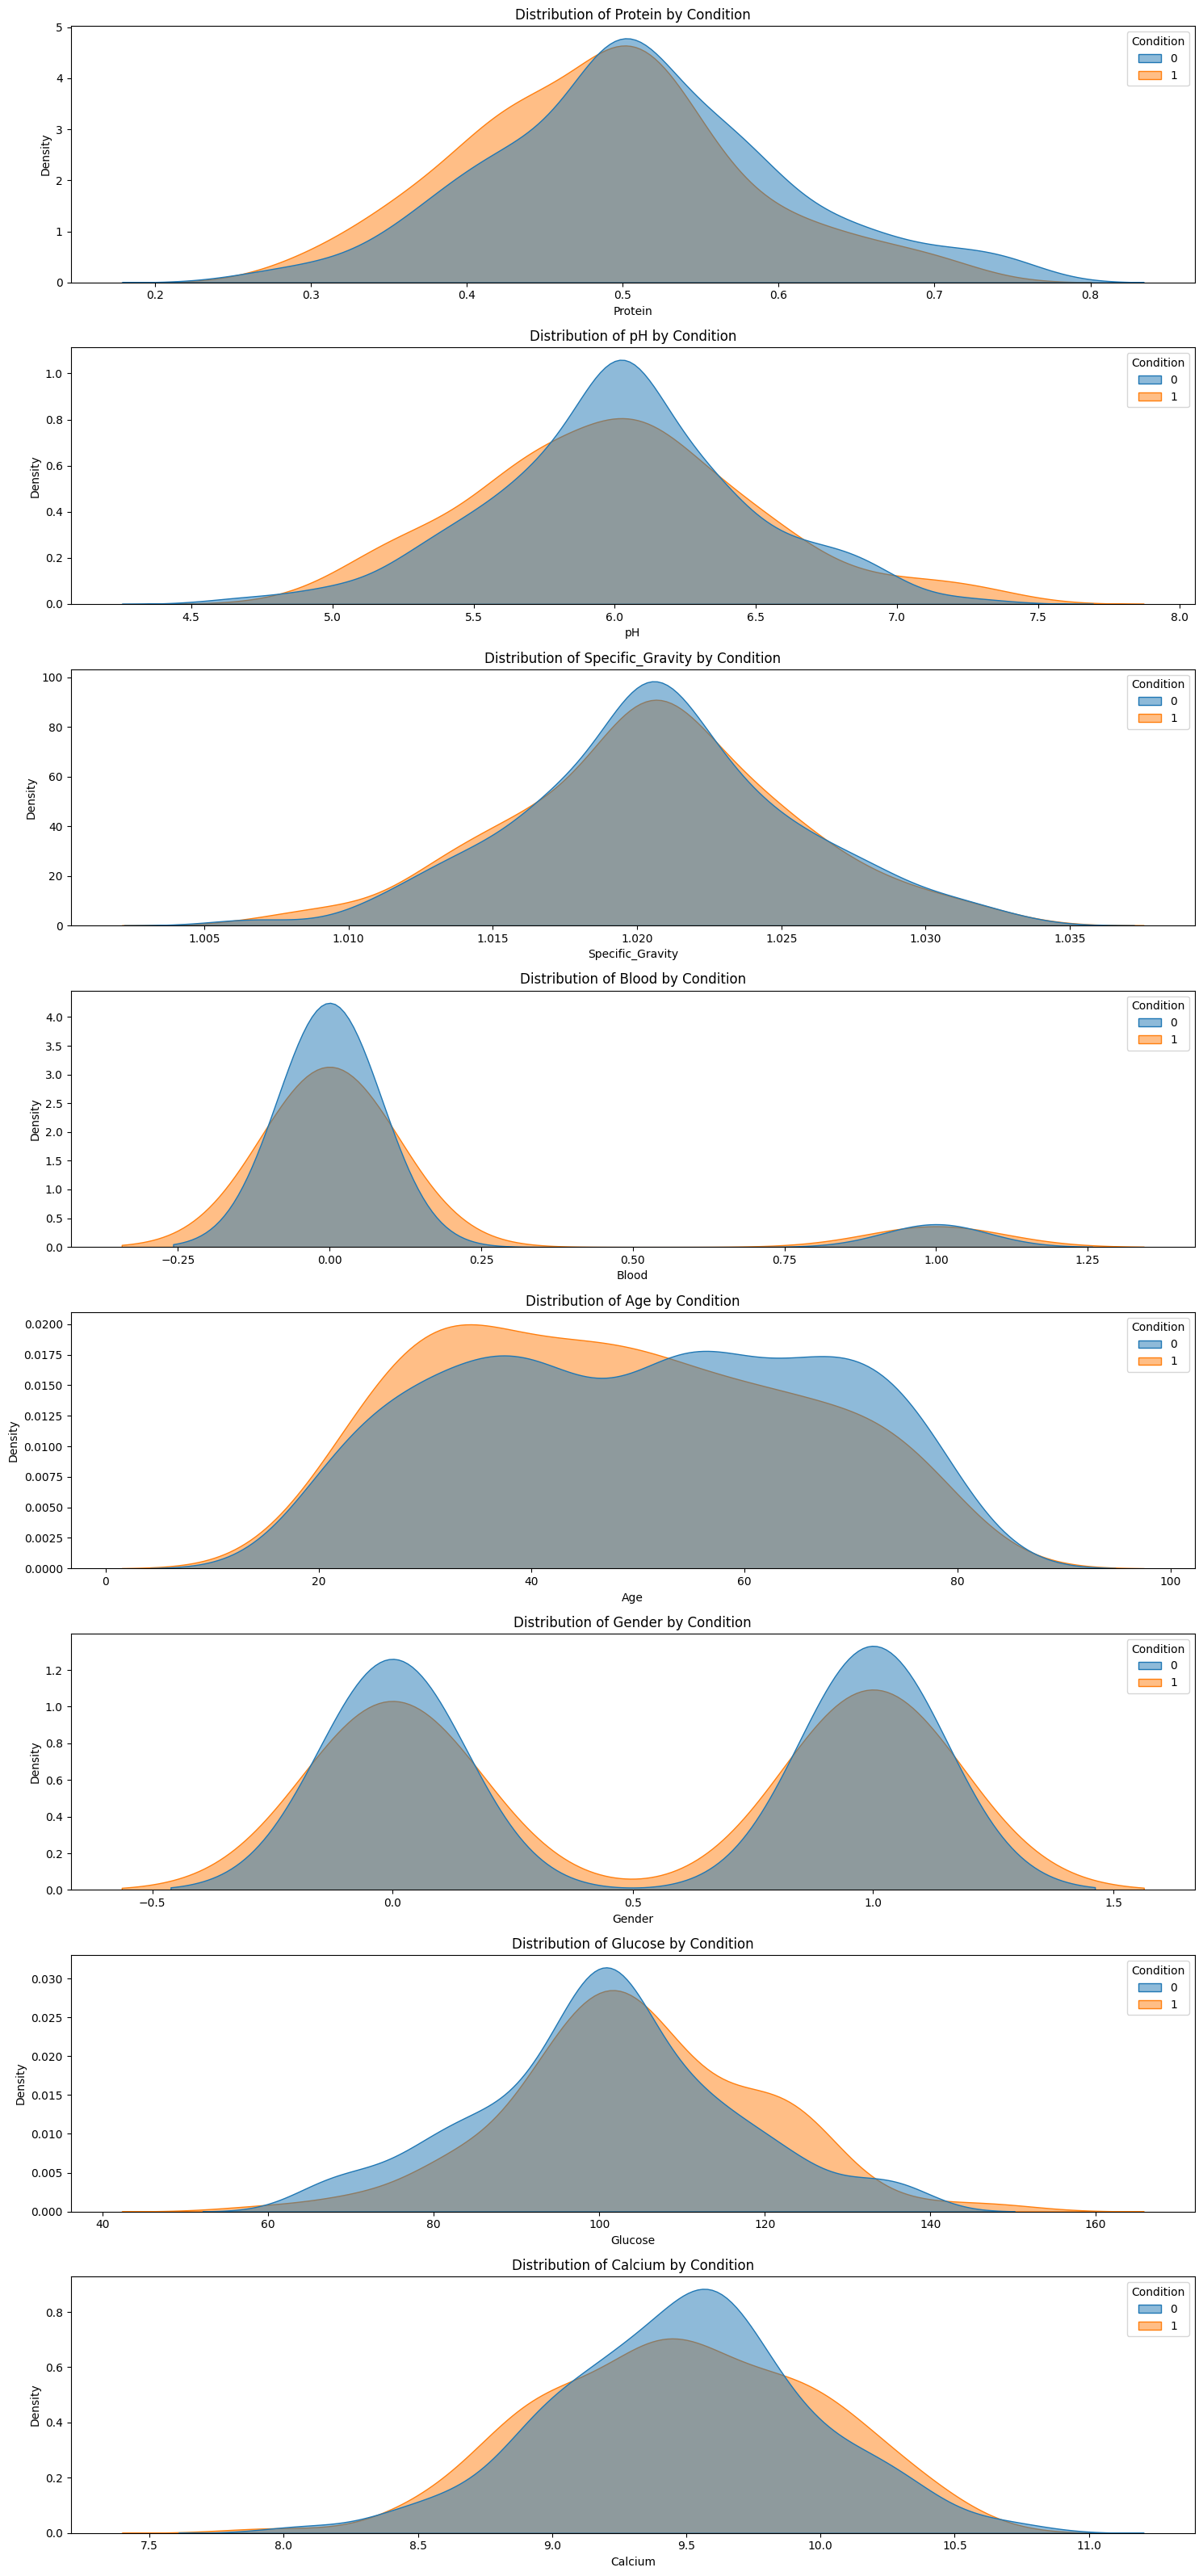

In [19]:
plot_feature_distribution_by_condition(raw_data)

Observations:

* Protein: The distribution shows that healthier individuals tend to have slightly higher protein levels, peaking around 0.5. In contrast, not-healthy individuals show a broader distribution that slightly shifts towards lower protein values. This could imply that lower protein levels might be associated with health issues.

* pH: Healthy individuals tend to have a pH distribution more centered around 6.0, whereas the not-healthy group has a slightly broader distribution towards the acidic side (around 5.5). This could suggest that maintaining a neutral to slightly basic pH might be associated with better health.

* Specific Gravity: Both conditions show a very similar distribution with peaks around 1.020, suggesting that specific gravity may not be a strong indicator of health status in this dataset. This could imply that hydration levels (often reflected by specific gravity) are relatively consistent across both healthy and not-healthy individuals.

* Blood: The blood distribution shows that healthier individuals have a higher concentration around the zero mark, implying fewer blood abnormalities. In contrast, not-healthy individuals show a wider distribution, which might indicate that blood eceptions (like the presence of blood in urine) could be more common among not-healthy individuals.

* Age: The age distribution indicates that healthier individuals are relatively evenly distributed across various age groups, while not-healthy individuals tend to peak around the age of 60. This suggests that the likelihood of health issues might increase with age, highlighting age as a potential risk factor.

* Gender: The distribution indicates that health status varies between genders. Not-healthy individuals show a higher density among females, while healthy individuals show a higher density among males. This suggests that females may be more likely to be classified as not-healthy compared to males.

* Glucose: Healthier individuals show a peak around 100, while not-healthy individuals have a broader distribution that stretches towards higher glucose levels. This indicates that high glucose levels might be associated with not-healthy conditions, suggesting a link to conditions such as diabetes or metabolic syndromes.

* Calcium: The distribution for calcium shows that healthy individuals have a slightly higher peak around 9.5 compared to not-healthy individuals. This suggests that calcium levels are somewhat consistent between both groups, but higher calcium may still have a slight association with better health.

#### Correlation Matrix

In [12]:
def plot_correlation_matrix(
    data : pd.DataFrame,
    features : list = features,
    label : str = label
    ):
  """
  Plot a correlation matrix for the specified features.

  Parameters:
  - data (pd.DataFrame): The input DataFrame containing patient urine analysis results and labels.
  - features (list): List of feature names to include in the correlation matrix.
  """
  correlations = data[features].corrwith(data[label]).sort_values(ascending=False)

  plt.figure(figsize=(10, 8))
  sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title(f'Correlation with {label}')
  plt.show()

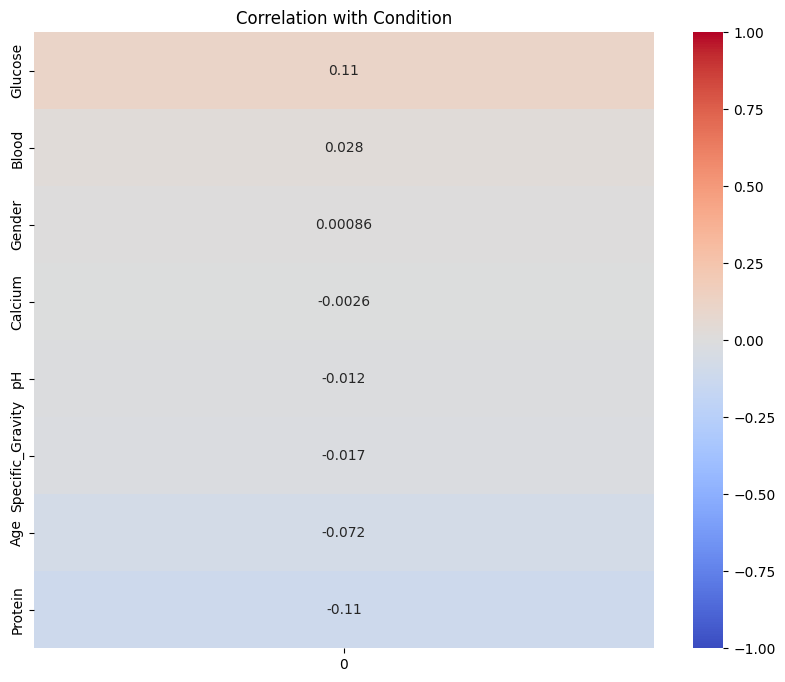

In [13]:
plot_correlation_matrix(raw_data)

Observations:

* Glucose: Has a positive correlation of 0.11 with the condition. This suggests that higher glucose levels are somewhat associated with the presence of the condition.
* Blood: Has a small positive correlation of 0.028.

* Gender: Has a very slight positive correlation of 0.00086, indicating almost no correlation with the condition.

* Calcium: Has a negligible negative correlation of -0.0026.

* pH: Shows a small negative correlation of -0.012.

* Age: Has a negative correlation of -0.017.

* Specific Gravity: Shows a moderate negative correlation of -0.072.

* Protein: Has a negative correlation of -0.11, similar in magnitude to the positive correlation observed with glucose.

Overall, Glucose and Protein show the strongest correlations with the condition, though neither is particularly strong. This might suggest that while they are the most relevant features, they are not crucial factors of the condition on their own.

### Model Building

#### Scaling

In the data, Features like Age, Glucose, and Specific_Gravity have different ranges and units. Without scaling, these differences can lead to features with larger ranges having more influence on the model.

Therefore, I decided to scale continous features, and leave discrite and categorical as is.

In [ ]:
scaler = StandardScaler()

In [22]:
raw_data[continous_features] = scaler.fit_transform(raw_data[continous_features])
raw_data.head(10)

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.491531,0.976206,1.347209,0,0.849669,1,-1.295893,-0.794485,1
1,2,-0.183044,2.041715,0.843384,0,0.083245,0,-0.292286,0.375839,1
2,3,0.651920,-1.543055,-0.074649,0,1.026536,0,-0.383792,-0.280731,0
3,4,-0.026466,0.582607,-0.824532,0,-0.506311,0,-0.022840,0.284206,0
4,5,-0.284913,-0.732550,0.603094,0,-1.567513,0,-0.315710,-0.703974,0
5,6,-0.284896,-0.555351,0.279674,0,-1.508557,1,-0.181493,1.780893,0
6,7,1.641534,-0.669427,0.812139,0,0.378024,0,-0.022840,0.990410,1
7,8,-0.026466,-0.963749,0.536177,0,0.613846,1,-1.205880,0.066760,0
8,9,-0.534909,0.025115,0.975961,0,1.085491,0,0.607138,1.821138,0
9,10,0.540236,-0.927944,-0.705983,0,-1.036912,1,1.002565,0.110686,0


#### Handeling Imbalancing

As showed before, the data is imbalanced with the label 'Condition'.
'Condition' might not be the only imbalanced feature, so I will check all categorical fatures to make sure the data set is balnced along all features.

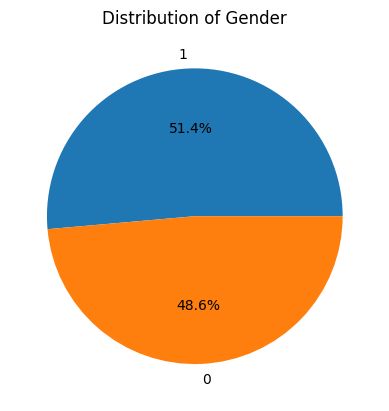

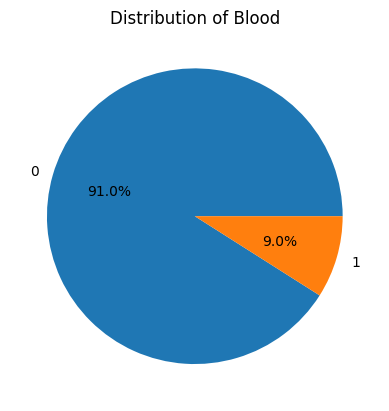

In [88]:
for feature in categorical_features:
    plot_pie_chart(raw_data, feature=feature)

'Blood' and 'Condition' features are imbalanced.
In order to recieve a more robust model I will use stratified balancing

#### Preparing the Data for ML Models

##### Train Test Split

In [91]:
X = raw_data.drop(label, axis=1)
y = raw_data[label]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=raw_data[[label, 'Blood']]
    )

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (350, 9)
X_test shape: (150, 9)


##### Over Sampeling

In order to create new data samples for the minority class - not-healthy people (1), I will use the SMOTE algorithm.

SMOTE uses KNN in the background to create a bew data samples that close to the other class samples.